In [117]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.volume import MFIIndicator 
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator, StochasticOscillator
from ta.trend import MACD, CCIIndicator, ADXIndicator
from ta.volatility import BollingerBands, AverageTrueRange

In [118]:
# import sys 
# sys.path.append('C:\python\ps\duahettienday\Gui_Huy')
# from get_data_vn import get_data_ps

In [119]:
# data = get_data_ps(10000) 

In [120]:
# data.set_index('Date').Close.plot(figsize = (18,6))

In [121]:
# Low-pass filter dùng cho lọc nhiễu data
from scipy.signal import butter,lfilter 
def lowpass_filter(signal, ratio):
    b, a = butter(1, ratio, btype='low', analog=False)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

In [122]:
#path to expiration_date file
df = pd.read_csv('./expiration_date.csv') 
df['Date'] = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2195, 12, 17),
 datetime.date(2052, 7, 18),
 datetime.date(2128, 11, 18),
 datetime.date(2238, 6, 21),
 datetime.date(2127, 6, 19),
 datetime.date(2070, 3, 20),
 datetime.date(2101, 12, 15),
 datetime.date(2167, 9, 17),
 datetime.date(2136, 4, 19),
 datetime.date(2248, 6, 15),
 datetime.date(2130, 3, 16),
 datetime.date(2027, 11, 18),
 datetime.date(2208, 12, 15),
 datetime.date(2078, 3, 17),
 datetime.date(2154, 10, 17),
 datetime.date(2108, 11, 15),
 datetime.date(2088, 3, 18),
 datetime.date(2077, 8, 19),
 datetime.date(2088, 11, 18),
 datetime.date(2110, 10, 16),
 datetime.date(2072, 10, 20),
 datetime.date(2120, 10, 17),
 datetime.date(2038, 7, 15),
 datetime.date(2170, 10, 18),
 datetime.date(2029, 7, 19),
 datetime.date(2084, 9, 21),
 datetime.date(2222, 4, 18),
 datetime.date(2090, 6, 15),
 datetime.date(2158, 10, 19),
 datetime.date(2070, 4, 17),
 datetime.date(2214, 4, 21),
 datetime.date(2247, 8, 19),
 datetime.date(2070, 1, 16),
 datetime.date(2100, 8, 19),
 

In [123]:
# import sys#Thay Z bằng tên ổ nas máy cá nhân
# sys.path.append('Z:\Data\API_Chien')
# from get_data_vn import get_data_ps
# #Lấy dữ liệu phái sinh
# data=get_data_ps(3000)
# data = data.set_index("Date")
# data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
# data = data.reset_index() 

In [124]:
# data

In [125]:
# data.to_csv('data1min.csv')

In [126]:
data = pd.read_csv('./data1min.csv')

In [127]:
data.Date = pd.to_datetime(data.Date, errors='coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index() 

In [128]:
# #Momentum Indicators
# data['RSI'] = RSIIndicator(data['Close'], window=14).rsi()
# data['Stoch_K'] = StochasticOscillator(high = data["High"], low = data['Low'], close = data["Close"], window = 14, smooth_window = 3).stoch()
# data['Stoch_D'] = StochasticOscillator(high = data["High"], low = data['Low'], close = data["Close"], window = 14, smooth_window = 3).stoch_signal()
# data['Awesome_Oscillator'] = AwesomeOscillatorIndicator(high = data["High"], low = data['Low'], window1 = 5, window2 = 34).awesome_oscillator()
# data['CCI'] = CCIIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=20, constant=0.015).cci()
# data['MFI'] = MFIIndicator(high=data['High'], low=data['Low'], close=data['Close'], volume=data['Volume'], window=14).money_flow_index()


In [129]:
import numpy as np
import pandas as pd
import datetime
from ta.volume import MFIIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange

def alpha(
    data: pd.DataFrame,
    params: dict,
    expiration_dates=None,   # iterable[date] hoặc None
):
    """
    Cột bắt buộc: ['Date','Open','High','Low','Close','Volume']
    params:
      - t1: (nếu bạn dùng lowpass_filter cho Close_filtered)
      - w1: cửa sổ chỉ báo (MFI/ATR)
      - t2, t3: ngưỡng MFI vào lệnh (giữ nguyên logic của bạn)
      - t4, t5: ngưỡng MFI thoát lệnh (giữ nguyên logic của bạn)

      -- ATR-based risk params --
      - atr_sl: hệ số SL theo ATR (vd 0.8)
      - atr_tp: hệ số TP theo ATR (vd 1.2)
      - use_trailing: True/False (trailing SL mỗi bar)
        * Long: SL = max(SL cũ, Close - atr_sl*ATR)
        * Short: SL = min(SL cũ, Close + atr_sl*ATR)
      - exec_on_close: True/False (True = ra/vào tính tại close của bar hiện tại;
                                   False = tín hiệu tại bar t, thực thi bar t+1 để tránh lookahead)
    """
    df = data.copy()

    # Ép kiểu datetime
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])

    # (Tuỳ bạn có dùng lọc hay không; bên dưới dùng Close thô cho chỉ báo)
    # Nếu muốn dùng lọc: hãy thay close_src = df['Close_filtered']
    close_src = df['Close']

    # Tính chỉ báo
    w1 = params['w1']
    df['MFI'] = MFIIndicator(high=df['High'], low=df['Low'], close=close_src,
                             volume=df['Volume'], window=w1).money_flow_index()
    df['RSI'] = RSIIndicator(close_src, window=14).rsi()
    df['ATR'] = AverageTrueRange(high=df['High'], low=df['Low'], close=close_src,
                                 window=w1).average_true_range()

    # Ngưỡng logic MFI gốc của bạn
    t2 = params['t2']  # vào short khi MFI < t2
    t3 = params['t3']  # vào long  khi MFI > t3
    t4 = params['t4']  # thoát short khi MFI > t4
    t5 = params['t5']  # thoát long  khi MFI < t5

    # Tham số ATR quản trị rủi ro
    atr_sl = params.get('atr_sl', 0.8)       # SL = ATR * atr_sl
    atr_tp = params.get('atr_tp', 1.2)       # TP = ATR * atr_tp
    use_trailing = params.get('use_trailing', True)
    exec_on_close = params.get('exec_on_close', True)

    expiration_set = set(expiration_dates) if expiration_dates is not None else set()
    warmup = w1  # chờ đủ ATR/MFI

    # Trạng thái
    pos = 0                 # -1 / 0 / +1
    position = []
    entry_price = np.nan
    sl = np.nan
    tp = np.nan

    # Để thực thi “tín hiệu t → khớp lệnh ở t+1” (tránh lookahead)
    desired_next = None   # vị thế mong muốn (áp dụng cho bar kế tiếp)
    prev_desired = 0

    for i in range(len(df)):
        ts   = df['Date'].iat[i]
        price= df['Close'].iat[i]
        MFI  = df['MFI'].iat[i]
        ATR  = df['ATR'].iat[i]

        # --- Thực thi lệnh từ bar trước (nếu chọn exec ở t+1) ---
        if not exec_on_close:
            # Ở bar i, thực thi quyết định của bar i-1
            if i == 0:
                pos = 0
            else:
                pos = prev_desired

        # Trong giai đoạn warmup hoặc NaN -> phẳng và reset risk state
        if (i < warmup) or np.isnan(MFI) or np.isnan(ATR):
            pos = 0
            entry_price = np.nan; sl = np.nan; tp = np.nan
            position.append(pos)
            prev_desired = pos if not exec_on_close else pos  # giữ đồng bộ
            continue

        # --- Cập nhật trailing SL nếu đang có vị thế ---
        if pos != 0 and use_trailing:
            if pos == 1:
                # Long: kéo SL lên theo Close - k*ATR
                sl = max(sl, price - atr_sl * ATR) if not np.isnan(sl) else price - atr_sl * ATR
            else:
                # Short: kéo SL xuống theo Close + k*ATR
                sl = min(sl, price + atr_sl * ATR) if not np.isnan(sl) else price + atr_sl * ATR

        # --- Kiểm tra chạm SL/TP (đóng lệnh) ---
        # Lưu ý: nếu bạn dùng dữ liệu OHLC intrabar, có thể kiểm tra theo High/Low thay vì Close
        if pos == 1:
            # Long: TP khi giá >= tp, SL khi giá <= sl
            if not np.isnan(tp) and price >= tp:
                pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan
            elif not np.isnan(sl) and price <= sl:
                pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan

        elif pos == -1:
            # Short: TP khi giá <= tp, SL khi giá >= sl
            if not np.isnan(tp) and price <= tp:
                pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan
            elif not np.isnan(sl) and price >= sl:
                pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan

        # --- Thoát theo MFI gốc của bạn (ưu tiên sau SL/TP) ---
        if pos == -1 and (MFI > t4):
            pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan
        elif pos == 1 and (MFI < t5):
            pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan

        # --- Entry theo MFI gốc của bạn (chỉ khi đang phẳng) ---
        if pos == 0:
            # vào short khi MFI < t2  (theo code gốc của bạn)
            if MFI < t2:
                pos = -1
                entry_price = price
                sl = entry_price + atr_sl * ATR
                tp = entry_price - atr_tp * ATR
            # vào long khi MFI > t3
            elif MFI > t3:
                pos = 1
                entry_price = price
                sl = entry_price - atr_sl * ATR
                tp = entry_price + atr_tp * ATR

        # --- EOD rules (giữ đúng tinh thần code gốc: chỉ đóng short lúc 14:25) ---
        if ts.hour == 14 and ts.minute == 25:
            if pos == -1:
                pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan

        if ts.hour == 14 and ts.minute == 45:
            if len(position) > 0:
                if ts.date() in expiration_set:
                    pos = 0; entry_price = np.nan; sl = np.nan; tp = np.nan

        # --- Ghi position ---
        if exec_on_close:
            # quyết định đã áp dụng ngay ở bar này
            position.append(pos)
            prev_desired = pos
        else:
            # lưu desired để thực thi bar sau
            desired_next = pos
            # pos thực thi hiện tại là quyết định của bar trước (đã set ở đầu vòng)
            position.append(pos)
            prev_desired = desired_next

    df['pos'] = position
    return df

In [130]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [131]:
import pandas as pd

In [132]:
# # pip install optuna ta pandas numpy
# import optuna
# import numpy as np
# import pandas as pd

# # ==== Metric & backtest (gọn, không lookahead) ====
# def compute_metrics(df, price_col='Close', pos_col='pos',
#                     slip_bps=1.0, fee_bps=1.0):
#     """
#     - slip_bps, fee_bps: chi phí mỗi lần đổi vị thế (basis points, 1 bps = 0.01%)
#     - Trả về Sharpe (annualized ~252 ngày), MDD, #trades
#     """
#     df = df.copy()

#     # Lợi nhuận theo % mỗi bar
#     ret = df[price_col].pct_change().fillna(0.0)
#     pos = df[pos_col].fillna(0.0)

#     # Khớp lệnh bar sau để tránh lookahead trong P&L
#     pos_shift = pos.shift(1).fillna(0.0)
#     strat_ret = ret * pos_shift

#     # Phí/ trượt giá khi thay đổi vị thế (đơn giản: khi |Δpos| > 0)
#     delta_pos = pos.diff().abs().fillna(0.0)
#     trade_cost = (slip_bps + fee_bps) / 10000.0
#     cost = delta_pos * trade_cost
#     # Trừ chi phí vào lợi nhuận
#     strat_ret = strat_ret - cost

#     # Gộp theo ngày để tính Sharpe ngày
#     if 'Date' in df.columns:
#         day = pd.to_datetime(df['Date']).dt.date
#         daily_ret = strat_ret.groupby(day).sum()
#     else:
#         daily_ret = strat_ret

#     mean = daily_ret.mean()
#     std  = daily_ret.std(ddof=1)
#     sharpe = 0.0 if std == 0 else (mean / std) * np.sqrt(252)

#     # MDD
#     eq = (1 + daily_ret).cumprod()
#     dd = (eq.cummax() - eq) / eq.cummax()
#     mdd = dd.max() if len(dd) else 0.0

#     # Số lần đổi vị thế (đếm “giao dịch”)
#     trades = int((delta_pos > 0).sum())

#     return {'sharpe': float(sharpe), 'mdd': float(mdd), 'trades': trades}

# # ==== Objective cho Optuna ====
# def make_objective(data, expiration_dates=None, base_params=None):
#     """
#     - data: DataFrame đã resample 10Min & reset_index (như bạn làm)
#     - alpha: dùng phiên bản bạn dán (có ATR/RSI/MFI…)
#     - base_params: bộ mặc định; sẽ được cập nhật bởi trial
#     """
#     base_params = dict(base_params or {})

#     def objective(trial: optuna.Trial):
#         # --- Search space ---
#         # MFI thresholds
#         t2 = trial.suggest_float('t2', 5, 40)    # into short: MFI < t2
#         t3 = trial.suggest_float('t3', 60, 95)   # into long : MFI > t3
#         t4 = trial.suggest_float('t4', 40, 85)   # exit short: MFI > t4
#         t5 = trial.suggest_float('t5', 15, 60)   # exit long : MFI < t5
#         # Cửa sổ chỉ báo
#         w1 = trial.suggest_int('w1', 10, 30)
#         # ATR risk params
#         atr_sl = trial.suggest_float('atr_sl', 0.2, 2.0)   # SL  = atr_sl * ATR
#         atr_tp = trial.suggest_float('atr_tp', 0.2, 3.0)   # TP  = atr_tp * ATR
#         use_trailing   = trial.suggest_categorical('use_trailing', [True, False])
#         exec_on_close  = trial.suggest_categorical('exec_on_close', [True, False])

#         # --- Ràng buộc logic mềm ---
#         penalty = 0.0
#         if not (t2 < t4):
#             penalty += (t2 - t4 + 1e-6)
#         if not (t5 < t3):
#             penalty += (t5 - t3 + 1e-6)

#         # --- Lắp tham số & chạy alpha ---
#         params = {
#             # giữ t1 nếu bạn dùng lowpass_filter ở nơi khác; không tối ưu ở đây
#             't1': base_params.get('t1', 0.75),
#             'w1': w1,
#             't2': t2, 't3': t3, 't4': t4, 't5': t5,
#             'atr_sl': atr_sl, 'atr_tp': atr_tp,
#             'use_trailing': use_trailing,
#             'exec_on_close': exec_on_close,
#         }

#         df_pos = alpha(data, params, expiration_dates=expiration_dates)

#         # --- Tính metric ---
#         metrics = compute_metrics(df_pos, slip_bps=1.0, fee_bps=1.0)
#         score = metrics['sharpe']

#         # phạt nếu ràng buộc sai
#         if penalty > 0:
#             score -= 5.0 * penalty  # hệ số phạt — có thể tăng

#         # (tùy chọn) phạt nếu quá ít giao dịch
#         if metrics['trades'] < 5:
#             score -= 0.5

#         # (tùy chọn) risk-aware
#         # score -= 0.5 * metrics['mdd']

#         trial.report(score, step=0)
#         return score

#     return objective

# # ==== Chạy study ====
# sampler = optuna.samplers.TPESampler(seed=42, multivariate=True, group=True)
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)

# study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
# # base_params: lấy đúng bộ bạn đang dùng làm mặc định
# base_params = {'t1': 0.75, 't2': 13, 't3': 81, 't4': 59, 't5': 37, 'w1': 14}
# study.optimize(make_objective(data, expiration_dates=None, base_params=base_params),
#                n_trials=200, show_progress_bar=True)

# print("Best Sharpe:", study.best_value)
# print("Best params:", study.best_params)

# # Backtest với bộ tốt nhất
# best_params = base_params.copy()
# best_params.update(study.best_params)
# df_best = alpha(data, best_params, expiration_dates=None)
# final = compute_metrics(df_best)
# print("Final metrics:", final)

In [ ]:
params = {'t1': 0.75, 't2': 15, 't3': 66, 't4': 55, 't5': 53, 'w1': 21}

In [142]:
# params = {'w1': 14, 'w2': 14, 'w3': 14, 'w4': 14, 't1': 0.75, 't2': 20, 't3': 81, 't4': 59, 't5': 37, 'w1': 14}
ds = alpha(data, params)

In [143]:
ds

Loading ITables v2.5.2 from the internet... (need help?)


In [144]:
# Trend Indicators

In [145]:
import warnings
warnings.filterwarnings("ignore")

Margin: 9.95
MDD: 55.0 (3.52%)

   Total trading quantity: 1037
         Profit per trade: 1.71
             Total Profit: 2256.5
         Profit after fee: 1775.3
 Trading quantity per day: 0.55
 Profit per day after fee: 0.94
                   Return: 0.15
          Profit per year: 233.0
                  HitRate: 0.49
          HitRate per day: 0.33


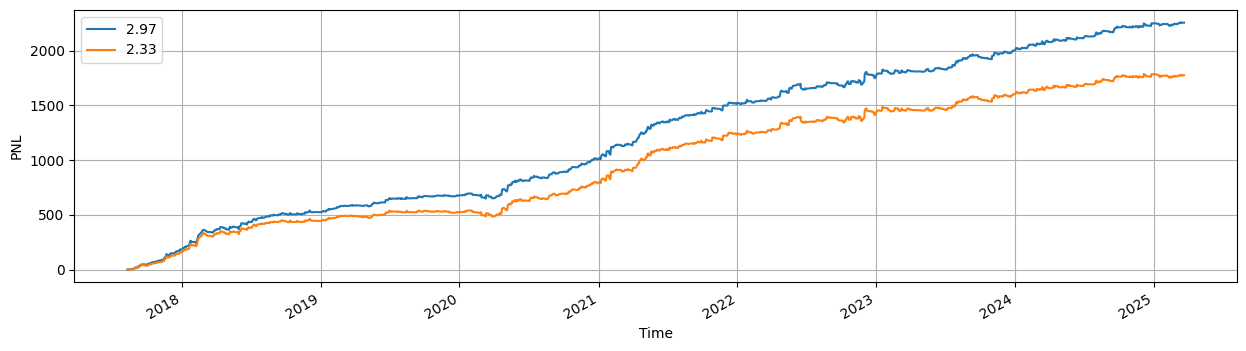

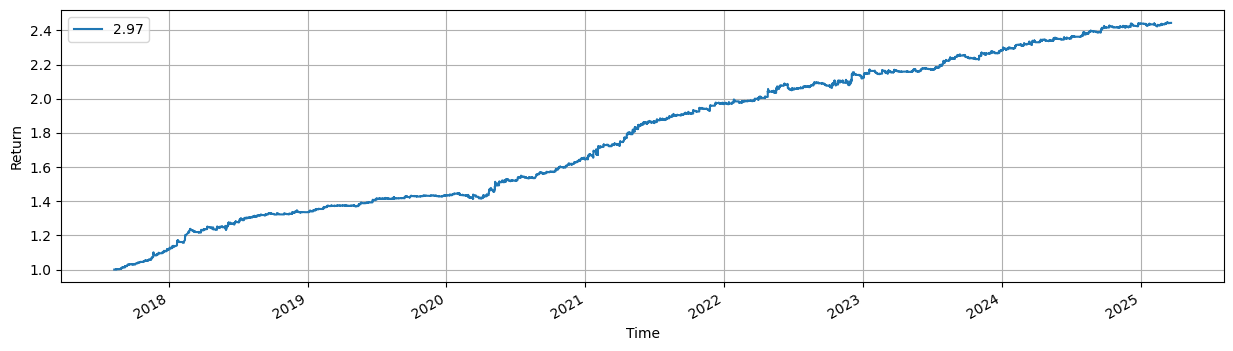

In [146]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [139]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [147]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)
